# BERT BASE MODEL DEVELOPMENT
Base model for binary and multiclassification against the NLTK corpus

### SETUP & LOAD DATA

In [2]:
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text --quiet
!pip install pydot --quiet
!pip install nltk --quiet
!pip install transformers --quiet
!pip install pyarrow -quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.6 MB/s eta 0:00:00

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
import random
import re

nltk.download('gutenberg')
from nltk.corpus import gutenberg

nltk.download('punkt')
from nltk.tokenize import sent_tokenize

from google.colab import drive

import pyarrow as pya
import pyarrow.parquet as pq

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# Mount drive to retrieve data frame
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from transformers import BertTokenizer, TFBertModel

from transformers import logging
logging.set_verbosity_error()

checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [6]:
MAX_SEQUENCE_LENGTH = 256

In [7]:
def create_bert_multiclass_model( model,
                                  train_layers=0,
                                  hidden_size=100,
                                  dropout=0.2,
                                  learning_rate=0.001):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        model.trainable = False

    else:
        model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')

    inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    out = model(inputs)

    pooler_token = out[1]
    #cls_token = out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)

    classification = tf.keras.layers.Dense(11, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [8]:
 bert_multiclass_model = create_bert_multiclass_model(bert_model)

In [ ]:
# Define a callback to save weights after each batch
#class SaveWeightsCallback(tf.keras.callbacks.Callback):
#    def on_batch_end(self, batch, logs=None):
#        model.save_weights(
#            f'/content/drive/My Drive/w266_Project/ProjectStore/model_weights_batch{batch}.h5')
from tensorflow.keras.callbacks import Callback

class SaveWeightsCallback(Callback):
    def __init__(self, model_name):
        super(SaveWeightsCallback, self).__init__()
        self.model_name = model_name

    def on_batch_end(self, batch, logs=None):
        model_filename = f"/content/drive/My Drive/w266_Project/ProjectStore/{self.model_name}_weights.h5"
        self.model.save_weights(model_filename)

    def on_epoch_end(self, epoch, logs=None):
        model_filename = f"/content/drive/My Drive/w266_Project/ProjectStore/{self.model_name}_weights_epoch{epoch}.h5"
        self.model.save_weights(model_filename)

save_weights_callback = SaveWeightsCallback(model_name='bert_multiclass_model')

# Create Encodings

In [9]:
def create_bert_encoding(data, label):
  data_encodings = bert_tokenizer(data,
                        max_length=MAX_SEQUENCE_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf')

  label_encodings = np.array(label)

  return (data_encodings, label_encodings)

In [10]:
# Create Train and Validation encodings
BATCH_SIZE = 100

# Load Test Data and prepare encodings


file_path = "/content/drive/My Drive/w266_Project/ProjectStore/"
train_file = file_path + "nltk_corpus_train_data_multi.parquet"
valid_file = file_path + "nltk_corpus_valid_data_multi.parquet"
test_file = file_path + "nltk_corpus_test_data_multi.parquet"

data = pya.parquet.read_table(train_file)
df_train = data.to_pandas()
data = pya.parquet.read_table(valid_file)
df_valid = data.to_pandas()
data = pya.parquet.read_table(test_file)
df_test = data.to_pandas()

train_data = []
train_label = []
valid_data = []
valid_label = []
test_data  = []
test_label = []

for indx, row in df_test.iterrows():
  train_data.append(row[0])
  train_label.append(row[1])
for indx, row in df_test.iterrows():
  valid_data.append(row[0])
  valid_label.append(row[1])
for indx, row in df_test.iterrows():
  test_data.append(row[0])
  test_label.append(row[1])

# Create a dataset
train_encodings, train_enc_label = create_bert_encoding(train_data, train_label)
valid_encodings, valid_enc_label = create_bert_encoding(valid_data, valid_label)
test_encodings, test_enc_label = create_bert_encoding(test_data, test_label)

dataset_training = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': train_encodings['input_ids'],
      'token_type_ids': train_encodings['token_type_ids'],
      'attention_mask': train_encodings['attention_mask']},
     train_enc_label))

dataset_training = dataset_training.batch(BATCH_SIZE)  # Batch size

dataset_validation = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': valid_encodings['input_ids'],
      'token_type_ids': valid_encodings['token_type_ids'],
      'attention_mask': valid_encodings['attention_mask']},
     valid_enc_label))

dataset_validation = dataset_validation.batch(BATCH_SIZE)

# Train Model

In [ ]:
# Train the model with the SaveWeightsCallback
bert_multiclass_model_history = bert_multiclass_model.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=1,
    callbacks=[save_weights_callback])


28/28 [==============================] - 7862s 284s/step - loss: 2.3329 - accuracy: 0.1707 - val_loss: 2.2200 - val_accuracy: 0.1921


In [ ]:
#train_encodings, train_enc_label = create_bert_partial_encoding(train_data[101:200],
#                                                                train_label[101:200])
#valid_encodings, valid_enc_label = create_bert_partial_encoding(valid_data[500:600],
#                                                                valid_label[500:600])

#model.load_weights("/content/drive/My Drive/w266 Project/ProjectStore/weights.h5")

In [ ]:
#import pickle

# Specify the file path for saving the history object
#history_file_path = '/content/drive/My Drive/w266_Project/ProjectStore/training_history.pkl'

# Save the history object to the specified file path using pickle
#with open(history_file_path, 'wb') as file:
#    pickle.dump(bert_classification_model_history.history, file)

In [ ]:
#train_encodings, train_enc_label = create_bert_partial_encoding(train_data[200:700],
#                                                                  train_label[200:700])
#valid_encodings, valid_enc_label = create_bert_partial_encoding(valid_data[500:600],
#                                                                  valid_label[500:600])

#model = create_bert_classification_model(bert_model, num_train_layers=0)
#model.load_weights("/content/drive/My Drive/w266 Project/ProjectStore/weights.h5")

#bert_classification_model_history = model.fit(
#    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
#    train_enc_label,
#    validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
#    valid_enc_label),
#    batch_size=8,
#    epochs=1)

#model.save_weights("/content/drive/My Drive/w266 Project/ProjectStore/weights.h5")

63/63 [==============================] - 1756s 27s/step - loss: 0.6923 - accuracy: 0.6060 - val_loss: 0.6290 - val_accuracy: 0.6700


In [ ]:
#model.save_weights("/content/drive/My Drive/w266 Project/ProjectStore/weights.h5")
#filename = "/content/drive/My Drive/w266 Project/ProjectStore/wgt"
#model.save_weights(filename)
#model.load_weights('/content/drive/My Drive/w266 Project/ProjectStore/wgt')

In [ ]:

#bert_classification_model_history = bert_classification_model.fit(
#    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
#    train_enc_label,
#    validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
#    valid_enc_label),
#    batch_size=8,
#    epochs=1)

# Evaluate Model

In [13]:
# Load stored model weights
checkpoint_path = "/content/drive/My Drive/w266_Project/ProjectStore/"
bert_multiclass_model.load_weights(checkpoint_path + 'bert_multiclass_model_weights_epoch0.h5')

In [ ]:
score = bert_multiclass_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                                  test_enc_label)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [14]:
predictions = bert_multiclass_model.predict(
    [test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
#predictions

86/86 [==============================] - 2744s 32s/step


In [19]:
for i in range (len(predictions)):
  print(predictions[i])


Streaming output truncated to the last 5000 lines.
[0.13525353 0.07065673 0.13884248 0.05158443 0.02872851 0.05029652
 0.08212066 0.06077227 0.05293688 0.15932944 0.16947858]
[0.11338625 0.09254164 0.06538434 0.0599241  0.0298811  0.04670248
 0.08993686 0.0639042  0.06108405 0.15992746 0.21732748]
[0.12643917 0.08277373 0.07400141 0.06217174 0.02959293 0.05447383
 0.09679015 0.08599606 0.05821081 0.13937584 0.19017437]
[0.12455657 0.0806603  0.09613289 0.06101532 0.02923738 0.05332179
 0.09945624 0.0685206  0.05953173 0.15533538 0.17223181]
[0.1211582  0.07565676 0.10277619 0.0625387  0.03252585 0.05356494
 0.09708895 0.07091807 0.0600339  0.15289855 0.17083983]
[0.12374222 0.07517731 0.10765954 0.0578067  0.02731758 0.05588289
 0.09810598 0.0683406  0.05781667 0.16207638 0.16607402]
[0.11968055 0.08517031 0.08490226 0.06306836 0.02850709 0.05280922
 0.10442974 0.07418097 0.05976013 0.14854589 0.17894538]
[0.1238398  0.07799172 0.08885381 0.06085951 0.03048621 0.05784495
 0.10968934 0.

In [21]:
np.savetxt('/content/drive/My Drive/w266_Project/ProjectStore/predictions_multi.csv', predictions)


In [27]:
test_label[2745]
#len(predictions)

8

In [ ]:
# Save the trained model
# to load the model again: model = load_model('...')
#bert_classification_model.save('/content/drive/My Drive/w266 Project/ProjectStore/bert_binclass_base_model.keras')

In [ ]:
score

[2.2444844245910645, 0.6986899375915527]

In [ ]:
predictions

array([[0.00072889],
       [0.00068637],
       [0.00048361],
       [0.00064717],
       [0.00050687]], dtype=float32)

In [45]:
from sklearn.metrics import confusion_matrix, classification_report

prediction_max = []
for i in range(len(predictions)):
  prediction_max.append(np.argmax(predictions[i]))

# Generate confusion matrix
conf_matrix = confusion_matrix(test_label, prediction_max)

# Calculate accuracy using TensorFlow
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(test_label, prediction_max)
accuracy_result = accuracy.result().numpy()

# Calculate precision, recall, and F1 score using TensorFlow
precision = tf.keras.metrics.Precision()
precision.update_state(test_label, prediction_max)
precision_result = precision.result().numpy()

recall = tf.keras.metrics.Recall()
recall.update_state(test_label, prediction_max)
recall_result = recall.result().numpy()

f1 = 2 * (precision_result * recall_result) / (precision_result + recall_result)

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy_result)
print("\nPrecision:", precision_result)
print("Recall:", recall_result)
print("F1 Score:", f1)

# Classification report using scikit-learn
class_report = classification_report(test_label, prediction_max)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0  19 370]
 [  0   0   0   0   0   0   0   0   0   7 182]
 [  0   0   0   0   0   0   0   0   0  14 236]
 [  0   0   0   0   0   0   0   0   0   6 138]
 [  0   0   0   0   0   0   0   0   0   3  51]
 [  0   0   0   0   0   0   0   0   0  10  76]
 [  0   0   0   0   0   0   0   0   0  16 224]
 [  0   0   0   0   0   0   0   0   0  17 174]
 [  0   0   0   0   0   0   0   0   0  21 167]
 [  1   0   0   0   0   0   0   0   0  41 471]
 [  0   0   0   0   0   0   0   0   0  17 487]]

Accuracy: 0.19213974

Precision: 0.858391
Recall: 0.9995761
F1 Score: 0.9236192426444707

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       389
           1       0.00      0.00      0.00       189
           2       0.00      0.00      0.00       250
           3       0.00      0.00      0.00       144
           4       0.00      0.00      0.00        54
           5       0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
f1

0.9236192426444707

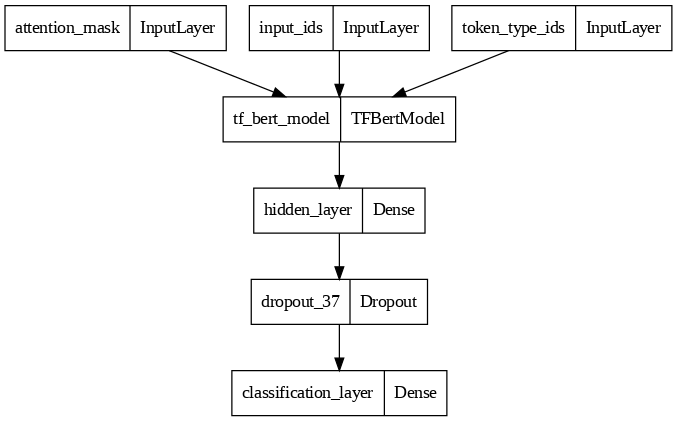

In [46]:
keras.utils.plot_model(bert_multiclass_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)